In [1]:
library(tidyverse)
library(infer)
library(broom)
library(gsDesign)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


### Data Cleaning & Wrangling

In [2]:
set.seed(301)

# Read, tidy, and summarise data from the web:
marketing_raw = read_csv(url("https://raw.githubusercontent.com/cadenmchan/stat301/main/marketing_AB.csv"))

# Convert categorical variables into factors
marketing_raw$test_group = as.factor(marketing_raw$test_group)
marketing_raw$most_ads_day = as.factor(marketing_raw$most_ads_day)

# Remove NA values (should be none)
marketing = na.omit(marketing_raw)

glimpse(marketing)
head(marketing, 5)

# Divide total_ads by 2 if user converted, and 
# Create a new feature, status, that combines the converted status and ad group
marketing = marketing %>%
    mutate(adj_total_ads = total_ads - total_ads * 0.5 * converted,
           status = as.factor(case_when(
               converted & test_group == "ad" ~ "AD: Converted",
               !converted & test_group == "ad" ~ "AD: Unconverted",
               converted & test_group == "psa" ~ "PSA: Converted",
               !converted & test_group == "psa" ~ "PSA: Unconverted"
            )))

Rows: 588101 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): test_group, most_ads_day
dbl (4): index, user_id, total_ads, most_ads_hour
lgl (1): converted

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 588,101
Columns: 7
$ index         <dbl> 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16…
$ user_id       <dbl> 1069124, 1119715, 1144181, 1435133, 1015700, 1137664, 11…
$ test_group    <fct> ad, ad, ad, ad, ad, ad, ad, ad, ad, ad, ad, ad, ad, ad, …
$ converted     <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, …
$ total_ads     <dbl> 130, 93, 21, 355, 276, 734, 264, 17, 21, 142, 209, 47, 6…
$ most_ads_day  <fct> Monday, Tuesday, Tuesday, Tuesday, Friday, Saturday, Wed…
$ most_ads_hour <dbl> 20, 22, 18, 10, 14, 10, 13, 18, 19, 14, 11, 13, 20, 13, …


index,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
<dbl>,<dbl>,<fct>,<lgl>,<dbl>,<fct>,<dbl>
0,1069124,ad,FALSE,130,Monday,20
1,1119715,ad,FALSE,93,Tuesday,22
2,1144181,ad,FALSE,21,Tuesday,18
3,1435133,ad,FALSE,355,Tuesday,10
4,1015700,ad,FALSE,276,Friday,14


### Part One: Simulated Sequential A/B Testing

**Data simulation**

Add the following columns: `day_num`, `week_num` and `simulated_date`
- `day_num`: Represents a numerical mapping of the weekdays (e.g., Monday as 1, Tuesday as 2) based on the day when the most ads were seen.
- `week_num`: A randomly assigned week number (ranging from 0 to 3) for each entry, simulating the allocation of data across four weeks.
- `simulated_date`: Combining day_num and week_num, to simulate a specific day in the 4-week data collection timeframe.

In [3]:
day_mapping <- c("Monday" = 1, "Tuesday" = 2, "Wednesday" = 3, "Thursday" = 4, 
                 "Friday" = 5, "Saturday" = 6, "Sunday" = 7)

set.seed(1234)
marketing_simulated = marketing %>%
    mutate(
        # Map 'most.ads.day' to a number
        day_num = day_mapping[most_ads_day],
        # Randomly assign each entry to one of the 4 weeks
        week_num = sample(0:3, nrow(marketing), replace = TRUE),
        # Create the simulated date (day within the 28-day period)
        simulated_date = day_num + week_num * 7)

head(marketing_simulated)

index,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour,adj_total_ads,status,day_num,week_num,simulated_date
<dbl>,<dbl>,<fct>,<lgl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<int>,<dbl>
0,1069124,ad,FALSE,130,Monday,20,130,AD: Unconverted,2,3,23
1,1119715,ad,FALSE,93,Tuesday,22,93,AD: Unconverted,6,3,27
2,1144181,ad,FALSE,21,Tuesday,18,21,AD: Unconverted,6,1,13
3,1435133,ad,FALSE,355,Tuesday,10,355,AD: Unconverted,6,1,13
4,1015700,ad,FALSE,276,Friday,14,276,AD: Unconverted,1,0,1
5,1137664,ad,FALSE,734,Saturday,10,734,AD: Unconverted,3,3,24


Extracting data from the first 14 batches:

In [4]:
batch_size = 3000
number_of_tests = 20

marketing_simulated_batches <- marketing_simulated %>%
    arrange(simulated_date) %>%
    mutate(batch_id = ceiling(row_number() / batch_size)) %>%
    filter(batch_id <= number_of_tests)
head(marketing_simulated_batches)

index,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour,adj_total_ads,status,day_num,week_num,simulated_date,batch_id
<dbl>,<dbl>,<fct>,<lgl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<int>,<dbl>,<dbl>
4,1015700,ad,FALSE,276,Friday,14,276,AD: Unconverted,1,0,1,1
36,1482561,ad,FALSE,112,Friday,22,112,AD: Unconverted,1,0,1,1
67,1275159,ad,FALSE,124,Friday,13,124,AD: Unconverted,1,0,1,1
94,1447938,ad,FALSE,593,Friday,15,593,AD: Unconverted,1,0,1,1
120,1228652,ad,FALSE,407,Friday,0,407,AD: Unconverted,1,0,1,1
155,1137456,ad,FALSE,46,Friday,9,46,AD: Unconverted,1,0,1,1


`incremental_batch_t_test` is a function designed to perform Welch's T-tests in batch increments. This function processes the dataset in fixed batches of a specified size (defaulting to 5000). For each batch, it extracts and compares samples from both groups, aggregating the results up to and including that batch.

In [5]:
# Reference Tutorial 2
incremental_batch_t_test <- function(data, alpha) {
  results_df <- tibble(
    batch_id = integer(),
    statistic = numeric(),
    p_value = numeric(),
    sample_size = integer(),
  )

  # Group by batch_id
  data_grouped <- data %>% group_by(batch_id)

  for(batch in unique(data_grouped$batch_id)) {
    # Select samples up to and including the current batch_id
    ad_sample <- filter(data, test_group == "ad", batch_id <= batch)$converted
    psa_sample <- filter(data, test_group == "psa", batch_id <= batch)$converted

    # Check if both groups have data up to the current batch
    if (length(ad_sample) > 0 && length(psa_sample) > 0) {
      # Perform Welch's T-test
      t_test_results <- t.test(
          as.numeric(ad_sample), 
          as.numeric(psa_sample),
          alternative = "greater",
          var.equal = FALSE
      )

      results_df <- rbind(results_df, tibble(
        batch_id = batch,
        statistic = round(t_test_results$statistic, 4),
        p_value = round(t_test_results$p.value, 4),
        sample_size = length(ad_sample) + length(psa_sample)
      ))
    }
  }

  return (results_df)
}



Perform `incremental_daily_t_test` for the first two weeks:

In [6]:
alpha = 0.05
results <- incremental_batch_t_test(marketing_simulated_batches, alpha)
results

batch_id,statistic,p_value,sample_size
<dbl>,<dbl>,<dbl>,<int>
1,1.3803,0.0843,3000
2,0.5523,0.2905,6000
3,1.0147,0.1554,9000
4,0.5249,0.2999,12000
5,0.1142,0.4545,15000
6,-0.0832,0.5332,18000
7,-0.3249,0.6273,21000
8,0.8293,0.2035,24000
9,1.5365,0.0623,27000


### Visualization of Critical Values in Sequential Testing:
This analysis involves four scenarios for determining critical values:

1. Unadjusted Critical Value (`unadjusted_crit`): The standard critical value for a given alpha level without any correction for multiple testing. It's calculated using the qnorm function, which finds the critical value from the standard normal distribution.

2. Bonferroni Critical Value (`bonferroni_crit`): Adjusts the critical value to account for multiple testing by dividing the alpha level by the number of tests (days). It's more conservative and increases the threshold for statistical significance.

3. Pocock Critical Value (`pocock_crit`): Obtained from the gsDesign function, which uses the Pocock method for sequential testing. This approach adjusts the critical value dynamically across multiple interim analyses.

4. O'Brien-Fleming Critical Value (`OF_crit`): Also derived using gsDesign, but with the O'Brien-Fleming method. This method is stringent in the early stages of testing and becomes less strict as the study progresses.

`sequential_crit_value_plot_with_correction` is to visualize these critical values: This plot displays the critical values of each batch obtained from the Welch's T-tests. Each batch is plotted on the x-axis against its critical value on the y-axis. There are four lines and points for each of the four correction methods (Unadjusted, Bonferroni, Pocock, and O'Brien-Fleming). It visually compares the observed critical values against the threshold values for each correction method over time.

In [7]:
unadjusted_crit <- qt(1 - 0.05 / 2, df = 599998)
unadjusted_crit

[1] 1.959968

In [8]:
bonferroni_crit<- qnorm(1 - alpha/number_of_tests)
bonferroni_crit

[1] 2.807034

In [9]:
design_pocock <- gsDesign(k = number_of_tests, #number of interim analysis planned
                          test.type = 1, # for one-sided tests
                          delta = 0, # default effect size
                          alpha = alpha, #type I error rate
                          beta = 0.2, # type II error rate
                          sfu = 'Pocock')
                          
pocock_crit<- design_pocock$upper$bound
pocock_crit

[1] 2.392309 2.392309 2.392309 2.392309 2.392309 2.392309 2.392309 2.392309
 [9] 2.392309 2.392309 2.392309 2.392309 2.392309 2.392309 2.392309 2.392309
[17] 2.392309 2.392309 2.392309 2.392309

In [10]:
design_of <- gsDesign(k = number_of_tests, #number of interim analysis planned
                      test.type = 1, # for one-sided tests
                      delta = 0, # default effect size
                      alpha = alpha, #type I error rate
                      beta = 0.2, # type II error rate
                      sfu = 'OF')
                          
OF_crit<- design_of$upper$bound
OF_crit

[1] 8.239096 5.825921 4.756845 4.119548 3.684636 3.363597 3.114086 2.912960
 [9] 2.746365 2.605431 2.484181 2.378422 2.285114 2.201991 2.127326 2.059774
[17] 1.998274 1.941974 1.890178 1.842318

Find the ealiest stopping day for each correction method. 

In [11]:
results_with_early_stopping_flag <- results %>%
  mutate(
      unadjust_stopping_flag = statistic > unadjusted_crit,
      bonferroni_stopping_flag = statistic > bonferroni_crit,
      pocock_stopping_flag = statistic > pocock_crit,
      OF_stopping_flag = statistic > OF_crit,
  )

first_unadjust_stopping_batch <- results_with_early_stopping_flag %>%
  filter(unadjust_stopping_flag) %>%
  arrange(batch_id) %>%
  slice(1) %>%
  .$batch_id
first_unadjust_stopping_batch

first_bonferroni_stopping_batch <- results_with_early_stopping_flag %>%
  filter(bonferroni_stopping_flag) %>%
  arrange(batch_id) %>%
  slice(1) %>%
  .$batch_id
first_bonferroni_stopping_batch <- "N/A"

first_pocock_stopping_batch <- results_with_early_stopping_flag %>%
  filter(pocock_stopping_flag) %>%
  arrange(batch_id) %>%
  slice(1) %>%
  .$batch_id


first_OF_stopping_batch <- results_with_early_stopping_flag %>%
  filter(OF_stopping_flag) %>%
  arrange(batch_id) %>%
  slice(1) %>%
  .$batch_id


stopping_batches_df <- tibble(
  Method = c("Unadjusted", "Bonferroni", "Pocock", "O'Brien-Fleming"),
  First_Stopping_Batch = c(first_unadjust_stopping_batch, 
                         first_bonferroni_stopping_batch, 
                         first_pocock_stopping_batch, 
                         first_OF_stopping_batch)
)
stopping_batches_df


[1] 11

Method,First_Stopping_Batch
<chr>,<chr>
Unadjusted,11
Bonferroni,N/A
Pocock,16
O'Brien-Fleming,16


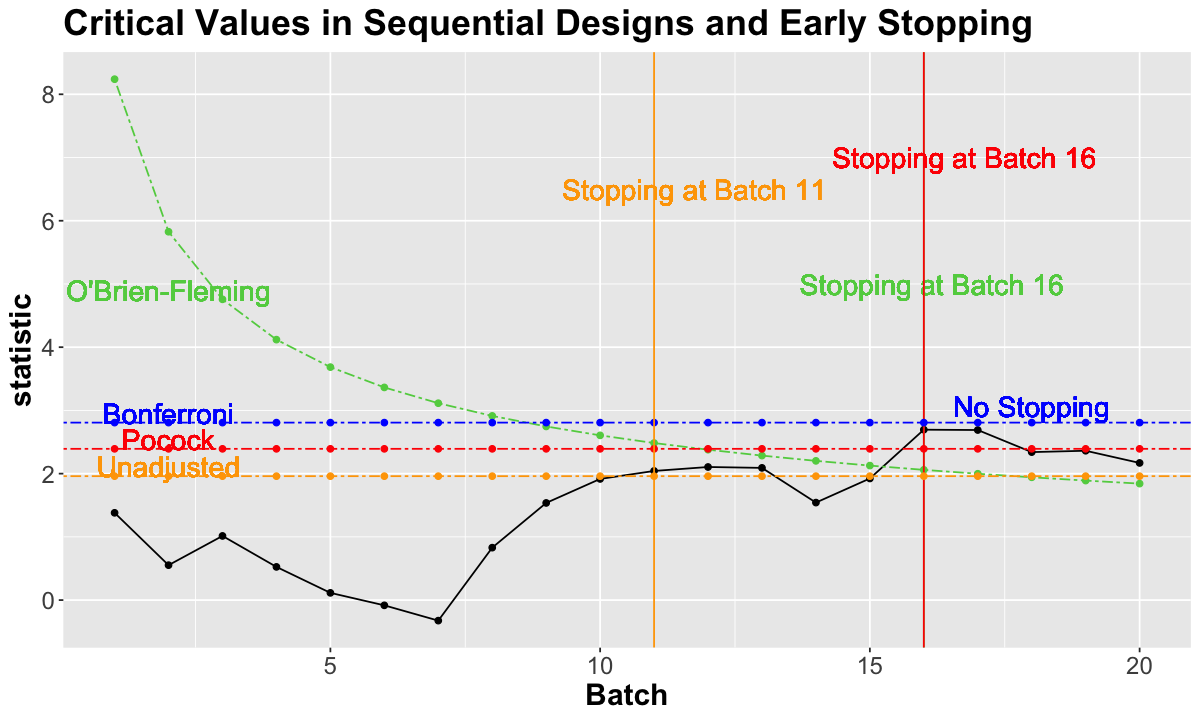

In [12]:
# reference: Tutorial 2 
options(repr.plot.width = 10, repr.plot.height = 6)

sequential_crit_value_plot <- 
  results %>%
  ggplot() +
  geom_line(aes(x = batch_id, y = statistic)) +
  theme(
    text = element_text(size = 18),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold")
  ) + 
  geom_point(aes(x = batch_id, y = statistic)) +
  ylab("statistic") +
  xlab("Batch")


sequential_crit_value_plot_with_correction <- 
  sequential_crit_value_plot + 
  ggtitle("Critical Values in Sequential Designs and Early Stopping")+

  geom_line(aes(x = batch_id, y = OF_crit),colour = 3, linetype = "twodash") +
  geom_point(aes(x = batch_id, y = OF_crit), colour = 3) +
  geom_text(x=2, y= OF_crit[3] + 0.15, size=6, label="O'Brien-Fleming",colour = 3)+
  geom_vline(xintercept = first_OF_stopping_batch, colour = 3) +
  geom_text(x=first_OF_stopping_batch + 0.15, y=5, size=6, label="Stopping at Batch 16",colour = 3)+

  geom_hline(yintercept = pocock_crit, colour = "red", linetype = "twodash") +
  geom_point(aes(x = batch_id, y = pocock_crit), colour = "red") +
  geom_text(x=2, y=pocock_crit + 0.15, size=6, label="Pocock",colour = "red")+
  geom_vline(xintercept = first_pocock_stopping_batch, colour = "red") +
  geom_text(x=first_pocock_stopping_batch+ 0.75, y=7, size=6, label="Stopping at Batch 16",colour = "red") +

  geom_hline(yintercept = bonferroni_crit, colour = "blue", linetype = "twodash") +
  geom_point(aes(x = batch_id, y = rep(bonferroni_crit, 20)), colour = "blue") +
  geom_text(x=2, y=bonferroni_crit + 0.15, size=6, label="Bonferroni",colour = "blue")+
  geom_text(x=18, y=bonferroni_crit + 0.25, size=6, label="No Stopping",colour = "blue")+

  geom_hline(yintercept = unadjusted_crit, colour = "orange", linetype = "twodash") +
  geom_point(aes(x = batch_id, y = rep(unadjusted_crit, 20)), colour = "orange") +
  geom_text(x=2, y=unadjusted_crit + 0.15, size=6, label="Unadjusted", colour = "orange")+
  geom_vline(xintercept = first_unadjust_stopping_batch, colour = "orange")+
  geom_text(x=first_unadjust_stopping_batch+ 0.75, y=6.5, size=6, label="Stopping at Batch 11",colour = "orange")

sequential_crit_value_plot_with_correction

### Part Two: Simulated A/A Testing

In [13]:
# Calculate the proportions of each group
prop_ad <- mean(marketing$test_group == "ad")
prop_psa <- 1 - prop_ad

# Print statements with labels
print(paste("Proportion of users in ad group:", prop_ad))
print(paste("Proportion of users in psa group:", prop_psa))

[1] "Proportion of users in ad group: 0.960000068015528"
[1] "Proportion of users in psa group: 0.039999931984472"


Simulate data for an A/A testing from populations.

In [14]:
set.seed(1234) # For reproducibility

# Parameters
n_batches <- 20
batch_size <- 3000
total_subjects <- n_batches * batch_size

# Baseline conversion rates
conversion_rate <- 0.5

# Number of 'ad' subjects (rounded to nearest integer)
n_ad <- round(total_subjects * prop_ad)

# Simulate data for a single distribution
total_conversions <- rbinom(total_subjects, 1, conversion_rate)

# Assign test groups with the specified proportion
# Ensure total subjects sum up correctly
test_groups <- c(rep('psa', total_subjects - n_ad), rep('ad', n_ad))

# Shuffle the test group assignments
shuffled_test_groups <- sample(test_groups)

# Create data frame
AA_data <- data.frame(
  batch_id = rep(1:n_batches, each = batch_size),
  subject_id = 1:total_subjects,
  test_group = shuffled_test_groups,
  converted = as.logical(total_conversions)
)


# View the first few rows of the data
head(AA_data)


,batch_id,subject_id,test_group,converted
,<int>,<int>,<chr>,<lgl>
1,1,1,ad,FALSE
2,1,2,ad,TRUE
3,1,3,ad,TRUE
4,1,4,ad,TRUE
5,1,5,ad,TRUE
6,1,6,ad,TRUE


Perform the same `incremental_batch_t_test` on the simulated A/A testing data.

In [15]:
AA_results <- incremental_batch_t_test(AA_data, alpha)
AA_results

batch_id,statistic,p_value,sample_size
<int>,<dbl>,<dbl>,<int>
1,0.2262,0.4107,3000
2,-0.9142,0.8193,6000
3,0.8743,0.1912,9000
4,1.0041,0.1579,12000
5,1.8052,0.0357,15000
6,1.7339,0.0417,18000
7,1.5669,0.0587,21000
8,2.1496,0.0159,24000
9,1.5682,0.0586,27000


In [16]:
AA_results_with_early_stopping_flag <- AA_results %>%
  mutate(
      unadjust_stopping_flag = statistic > unadjusted_crit,
      bonferroni_stopping_flag = statistic > bonferroni_crit,
      pocock_stopping_flag = statistic > pocock_crit,
      OF_stopping_flag = statistic > OF_crit,
  )

first_unadjust_stopping_batch <- AA_results_with_early_stopping_flag %>%
  filter(unadjust_stopping_flag) %>%
  arrange(batch_id) %>%
  slice(1) %>%
  .$batch_id

first_bonferroni_stopping_batch <- AA_results_with_early_stopping_flag %>%
  filter(bonferroni_stopping_flag) %>%
  arrange(batch_id) %>%
  slice(1) %>%
  .$batch_id
first_bonferroni_stopping_batch <- "N/A"

first_pocock_stopping_batch <- AA_results_with_early_stopping_flag %>%
  filter(pocock_stopping_flag) %>%
  arrange(batch_id) %>%
  slice(1) %>%
  .$batch_id
first_pocock_stopping_batch <- "N/A"

first_OF_stopping_batch <- AA_results_with_early_stopping_flag %>%
  filter(OF_stopping_flag) %>%
  arrange(batch_id) %>%
  slice(1) %>%
  .$batch_id
first_OF_stopping_batch <- "N/A"


AA_stopping_batches_df <- tibble(
  Method = c("Unadjusted", "Bonferroni", "Pocock", "O'Brien-Fleming"),
  First_Stopping_Batch = c(first_unadjust_stopping_batch, 
                         first_bonferroni_stopping_batch, 
                         first_pocock_stopping_batch, 
                         first_OF_stopping_batch)
)
AA_stopping_batches_df




Method,First_Stopping_Batch
<chr>,<chr>
Unadjusted,8
Bonferroni,N/A
Pocock,N/A
O'Brien-Fleming,N/A


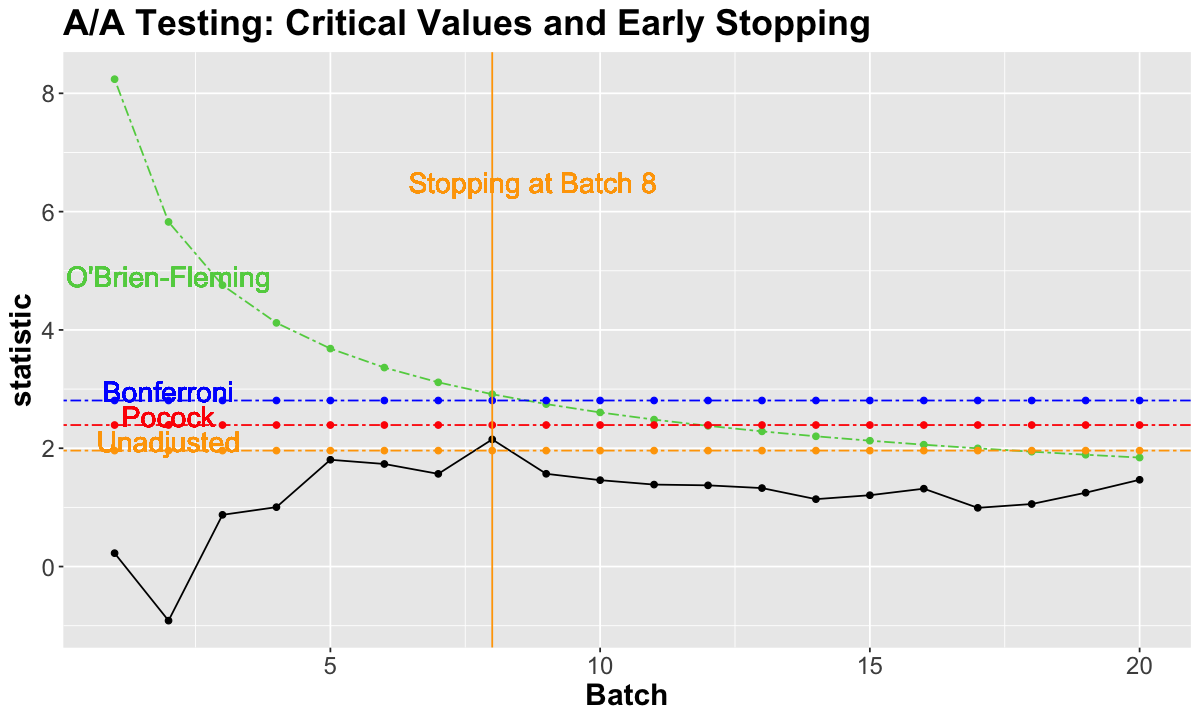

In [17]:
# reference: Tutorial 2 
options(repr.plot.width = 10, repr.plot.height = 6)

AA_sequential_crit_value_plot <- 
  AA_results %>%
  ggplot() +
  geom_line(aes(x = batch_id, y = statistic)) +
  theme(
    text = element_text(size = 18),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold")
  ) + 
  geom_point(aes(x = batch_id, y = statistic)) +
  ylab("statistic") +
  xlab("Batch")


AA_sequential_crit_value_plot_with_correction <- 
  AA_sequential_crit_value_plot + 
  ggtitle("A/A Testing: Critical Values and Early Stopping")+

  geom_line(aes(x = batch_id, y = OF_crit),colour = 3, linetype = "twodash")+
  geom_point(aes(x = batch_id, y = OF_crit), colour = 3) +
  geom_text(x=2, y= OF_crit[3] + 0.15, size=6, label="O'Brien-Fleming",colour = 3) +

  geom_hline(yintercept = pocock_crit, colour = "red", linetype = "twodash")+
  geom_point(aes(x = batch_id, y = pocock_crit), colour = "red") +
  geom_text(x=2, y=pocock_crit + 0.15, size=6, label="Pocock",colour = "red")+

  geom_hline(yintercept = bonferroni_crit, colour = "blue", linetype = "twodash") +
  geom_point(aes(x = batch_id, y = rep(bonferroni_crit, 20)), colour = "blue") +
  geom_text(x=2, y=bonferroni_crit + 0.15, size=6, label="Bonferroni",colour = "blue")+

  geom_hline(yintercept = unadjusted_crit, colour = "orange", linetype = "twodash") +
  geom_point(aes(x = batch_id, y = rep(unadjusted_crit, 20)), colour = "orange") +
  geom_text(x=2, y=unadjusted_crit + 0.15, size=6, label="Unadjusted", colour = "orange")+
  geom_vline(xintercept = first_unadjust_stopping_batch, colour = "orange")+
  geom_text(x=first_unadjust_stopping_batch+ 0.75, y=6.5, size=6, label="Stopping at Batch 8",colour = "orange")

AA_sequential_crit_value_plot_with_correction